In [29]:
import numpy as np
import pandas as pd
import os
import math
from pprint import pprint
from collections import defaultdict
import seq_helper as seqh
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import pairwise_distances
from scipy.spatial.distance import squareform, pdist
from sklearn.manifold.t_sne import (_joint_probabilities,
                                    _kl_divergence)

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
    
from matplotlib.cm import spectral
import matplotlib.pyplot as plt
import matplotlib as mpl

from numpy.linalg import norm
from numpy.linalg import eigh

import seq_helper as seqh

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

from sklearn.decomposition import TruncatedSVD

import networkx as nx
import community
import maxflow
import itertools as it


from sklearn.cluster.bicluster import SpectralBiclustering
from sklearn.metrics import consensus_score
from sklearn.cluster.bicluster import SpectralCoclustering

from sklearn.cluster import AffinityPropagation
from sklearn import metrics


from bokeh.plotting import gridplot, figure, show
from bokeh.io import output_notebook, push_notebook
from bokeh.models import ColumnDataSource, CustomJS
# Direct output to this notebook
output_notebook()

Loading BokehJS ...

In [30]:
F_path_name = ''.join(['./matrix_data/','F_with_norm.csv'])
Q_path_name = ''.join(['./matrix_data/','Q.csv'])
L_path_name = ''.join(['./matrix_data/','L.csv'])

F = np.array(pd.read_csv(F_path_name,sep=",", header = None))
Q = np.array(pd.read_csv(Q_path_name,sep=",", header = None))
L = np.array(pd.read_csv(L_path_name,sep=",", header = None))
L = np.reshape(L.astype(int),(-1))

L_limit = 174 # after 174 the label changes

data_num = F.shape[0]
F.shape, Q.shape, L.shape, data_num
#F = np.log(F)

((359, 256), (359, 35), (359,), 359)

In [31]:
Len_path_name = ''.join(['./matrix_data/','fragLenOutput.txt'])
Len = np.array(pd.read_csv(Len_path_name,sep="\t", header = None))
Len = np.array(Len[:,1:]).astype(np.float)

In [32]:
Len_n = np.zeros_like(Len)
for i in range(data_num):
    den = np.sum(Len[i,:])
    Len_n[i,:] = (Len[i,:]+1)/(den+Len_n.shape[1])

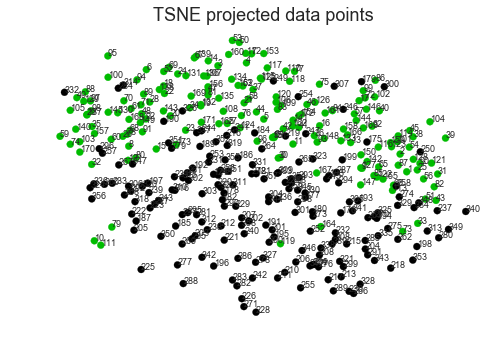

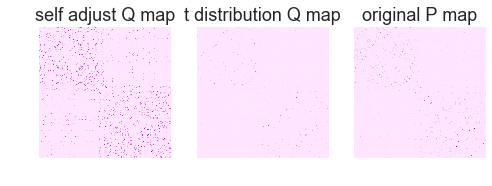

In [33]:
# TSNE
perplexity = 30.0
nc = 2
tsne = TSNE(n_components=nc, perplexity=perplexity,random_state=0)
F_reduced = tsne.fit_transform(F)

#for i in label draw
plt.figure(figsize = (20,20))
fig, ax = plt.subplots()
c=[spectral(float(i) /nc) for i in L]
ax.scatter(F_reduced[:,0],F_reduced[:,1], c=c)

txt = [str(i) for i in range(data_num)] #[label_text_dict[i] for i in label]
for i in range(data_num):
    ax.annotate(txt[i], (F_reduced[i,0],F_reduced[i,1]),size=9)

plt.axis('off')
plt.aspect='equal'
plt.title('TSNE projected data points')
plt.show()

DL_map = pairwise_distances(F_reduced, squared=True)
Q_map_binary = _joint_probabilities(DL_map, perplexity, False)

Q_map_p = squareform(Q_map_binary)
pal = sns.light_palette("purple", as_cmap=True)

plt.subplot(131)
plt.imshow(Q_map_p, interpolation='None', cmap=pal)
plt.axis('off'), plt.title('self adjust Q map')

plt.subplot(132)
Q_map_t = seqh.convert_Y_to_Q_by_t_dist(F_reduced)

plt.imshow(Q_map_t, interpolation='None', cmap=pal)
plt.axis('off'), plt.title('t distribution Q map')

plt.subplot(133)
DH_map = pairwise_distances(F, squared=True)
P_map_binary = _joint_probabilities(DH_map, perplexity, False)

P_map = squareform(P_map_binary)
#P_map = _joint_probabilities_constant_sigma(D_map, 0.01)

plt.imshow(P_map, interpolation='None', cmap=pal)
plt.axis('off'), plt.title('original P map')
plt.show()

In [42]:
source = ColumnDataSource(data=dict(
    x=F_reduced[:,0], 
    y=F_reduced[:,1])
)
model = ColumnDataSource(data=dict(
    x=[],
    y_obs=[],
    y_pred=[],
))

source.callback = CustomJS(code="""
        // Define a callback to capture errors on the Python side
        function callback(msg){
            console.log("Python callback returned unexpected message:", msg)
        }
        callbacks = {iopub: {output: callback}};

        // Select the data
        var inds = cb_obj.selected['1d'].indices;
        var d1 = cb_obj.data;
        var x = []
        var y = []
        for (i = 0; i < inds.length; i++) {
            x.push(d1['x'][inds[i]])
            y.push(d1['y'][inds[i]])
        }
        
        // Generate a command to execute in Python              
        data = {
            'x': x,
            'y': y,
        }        
        var data_str = JSON.stringify(data)
        var cmd = "saved_selected(" + data_str + ")"

        // Execute the command on the Python kernel
        var kernel = IPython.notebook.kernel;
        kernel.execute(cmd, callbacks, {silent : false});
""")

def saved_selected(values):
    x = np.array(values['x'])
    y_obs = np.array(values['y'])
    
    # Sort by increasing x
    sorted_indices = x.argsort()
    x = x[sorted_indices]
    y_obs = y_obs[sorted_indices]

    if len(x) > 2:
        # Do a simple linear model
        A = np.vstack([x, np.ones(len(x))]).T
        m, c = np.linalg.lstsq(A, y_obs)[0]
        y_pred = m * x + c

        data = {'x': x,  'y_obs': y_obs, 'y_pred': y_pred}
        model.data.update(data)
        # Update the selected dict for further manipulation
        selected.update(data)
        # Update the drawing
        push_notebook(handle=handle)

selected = dict()
figkwds = dict(plot_width=500, plot_height=300, # webgl=True,
               x_axis_label='X', y_axis_label='Y',
               tools="pan,lasso_select,box_select,reset,help")
p1 = figure(active_drag="lasso_select", **figkwds)
palette=[]
for i in L:
    if i==0:
        palette.append('green')
    else:
        palette.append('blue')
p1.scatter('x', 'y', source=source, alpha=0.8)

handle = show(p1, notebook_handle=True)
fore_points = selected
len(fore_points)

0

In [43]:
selected = dict()

figkwds = dict(plot_width=500, plot_height=300, # webgl=True,
               x_axis_label='X', y_axis_label='Y',
               tools="pan,lasso_select,box_select,reset,help")

p1 = figure(active_drag="lasso_select", **figkwds)
p1.scatter('x', 'y', source=source, alpha=0.8)

handle = show(p1, notebook_handle=True)
back_points = selected


In [44]:
back_node_xy = np.hstack((np.reshape(back_points['x'],(-1,1)),np.reshape(back_points['y_obs'],(-1,1))))
fore_node_xy = np.hstack((np.reshape(fore_points['x'],(-1,1)),np.reshape(fore_points['y_obs'],(-1,1))))

back_node = []
fore_node = []
for j in range(back_node_xy.shape[0]):
    for i in range(data_num):
        if np.array_equal(F_reduced[i,:], back_node_xy[j,:]):
            back_node.append(i)

for j in range(fore_node_xy.shape[0]):
    for i in range(data_num):
        if np.array_equal(F_reduced[i,:], fore_node_xy[j,:]):
            fore_node.append(i)     
            


In [45]:
len(back_node), len(fore_node)

(54, 71)

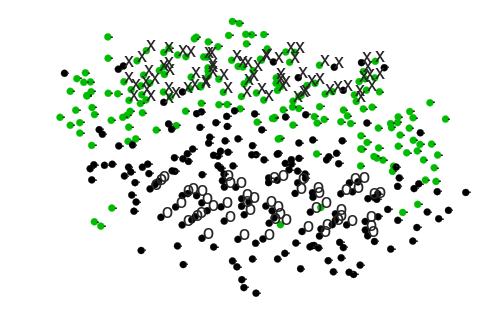

In [46]:
#fore_node = (model.get_indices(5)[0])
#back_node = (model.get_indices(1)[0])

#sample_num = 10
#fore_node = np.random.permutation(L_limit)[:sample_num]
#back_node = (np.random.permutation(data_num-L_limit)+L_limit)[:sample_num]

color_list = np.array(['.' for i in range(data_num)])
color_list[fore_node] = 'x'
color_list[back_node] = 'o'

fig, ax = plt.subplots()
c=[spectral(float(i) /nc) for i in L]
ax.scatter(F_reduced[:,0],F_reduced[:,1], c=c)
txt = [str(i) for i in color_list] #[label_text_dict[i] for i in label]
for i in range(data_num):
    ax.annotate(txt[i], (F_reduced[i,0],F_reduced[i,1]),size=20)
plt.axis('off')
plt.show()

In [47]:
bin_size = 5
x_max, x_min = np.max(F_reduced[:,0]), np.min(F_reduced[:,0])
y_max, y_min = np.max(F_reduced[:,1]), np.min(F_reduced[:,1])
print(x_max, x_min, y_max, y_min)
x_list = [x_min+i*bin_size for i in range(1+math.ceil(( x_max-x_min)/5))]
y_list = [y_min+i*bin_size for i in range(1+math.ceil(( y_max-y_min)/5))]

fore_hist, xedges, yedges = np.histogram2d(F_reduced[fore_node][:,0], F_reduced[fore_node][:,1], bins=(x_list, y_list))
fore_pmf = (fore_hist + 1)/(np.sum(fore_hist)+fore_hist.shape[0]*fore_hist.shape[1] )
back_hist, xedges, yedges = np.histogram2d(F_reduced[back_node][:,0], F_reduced[back_node][:,1], bins=(x_list, y_list))
back_pmf = (back_hist + 1)/(np.sum(back_hist)+back_hist.shape[0]*back_hist.shape[1] )

43.4904611165 -44.313685954 54.5663802748 -21.009968229


In [48]:
lamb = 1000        # boost region 
is_add_hard_constraint = True
N_neighbor = 20
K_upper_limit = 100*lamb


In [49]:
# define region cost
fore_region_cost = []
back_region_cost = []
s_link_list = []
t_link_list = []

for i in range(data_num):
    p = F_reduced[i,:]
    
    fore_c = seqh.get_prob_from_prob_bin(p[0],p[1], fore_pmf, xedges, yedges)
    back_c = seqh.get_prob_from_prob_bin(p[0],p[1], back_pmf, xedges, yedges)    
    s_link_list.append(fore_c)
    t_link_list.append(back_c)
    
    if is_add_hard_constraint:
        if i in fore_node:
            fore_c = K_upper_limit  
            back_c = 0
        elif i in back_node:
            fore_c = 0
            back_c = K_upper_limit             
               
    
    fore_region_cost.append(fore_c)
    back_region_cost.append(back_c)
    
fore_region_cost = np.array(fore_region_cost)
back_region_cost = np.array(back_region_cost)
s_link_list = np.array(s_link_list)
t_link_list = np.array(t_link_list)

In [50]:
P_tr_map, P_neighbor_index = seqh.get_N_neighbor(P_map, N_neighbor)
P_tr_map = P_tr_map*lamb

np.max(P_tr_map),np.max(s_link_list),np.max(t_link_list)

(1.1256571113859866, 0.013927576601671309, 0.011695906432748537)

In [51]:
# Create a graph with float capacities.
g = maxflow.Graph[float](data_num+2, N_neighbor*(data_num+2))
nodes = g.add_nodes(data_num)
for i in range(data_num):    
    neighbor_index = P_neighbor_index[i]
    for j in neighbor_index:
        g.add_edge(nodes[i], nodes[j], P_tr_map[i,j], P_tr_map[j,i])        
    g.add_tedge(nodes[i], fore_region_cost[i], back_region_cost[i])
    
flow = g.maxflow()
print("Maximum flow:", flow)    

Maximum flow: 56.194595763683914


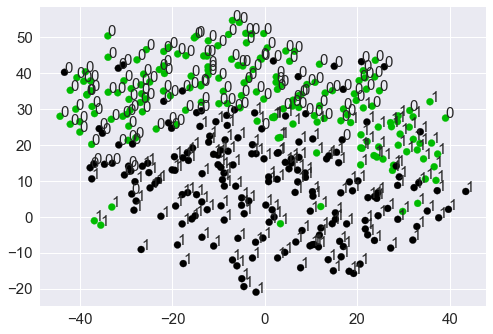

accuracy is  0.774373259053


In [52]:
A = []
for i in range(data_num):
    a = g.get_segment(nodes[i])
    A.append(a)

fig, ax = plt.subplots()
c=[spectral(float(i) /nc) for i in L]
ax.scatter(F_reduced[:,0],F_reduced[:,1], c=c)
txt = [str(i) for i in A] #[label_text_dict[i] for i in label]
for i in range(data_num):
    ax.annotate(txt[i], (F_reduced[i,0],F_reduced[i,1]),size=15)

plt.show()
acc, lumping_error, splitting_error = seqh.evaluate_performance(L,A) 
print('accuracy is ', acc)

lumping_error is  15744
splitting is  15774
accuracy is  0.573816155989


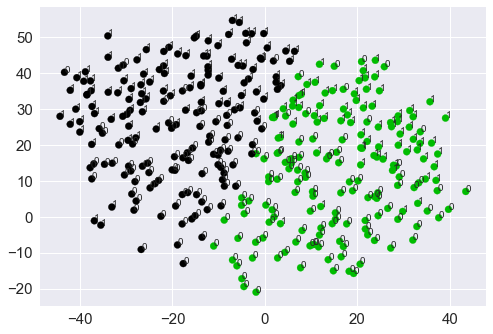

In [17]:
seqh.classify_with_Kmeans(F_reduced, L, init='k-means++')

In [ ]:
preference = 10
AP_map = Q_map_t+preference*np.eye(data_num)

af = AffinityPropagation( affinity='precomputed').fit(AP_map)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(L, labels))
print("Completeness: %0.3f" % metrics.completeness_score(L, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(L, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(L, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(L, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(F_reduced, labels, metric='sqeuclidean'))

import matplotlib.pyplot as plt
from itertools import cycle

plt.close('all')
plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = F_reduced[cluster_centers_indices[k]]
    plt.plot(F_reduced[class_members, 0], F_reduced[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in F_reduced[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [ ]:
nc = 6
the_map = Q_map_p
model = SpectralCoclustering(n_clusters=nc, random_state=10000)
model.fit(the_map)

fit_data = the_map[np.argsort(model.row_labels_)]
fit_data = fit_data[:, np.argsort(model.column_labels_)]

plt.matshow(fit_data, cmap=plt.cm.Blues)
plt.title("After biclustering; rearranged to show biclusters")
plt.axis('off')
plt.show()

fig, ax = plt.subplots()
c=[spectral(float(i) /nc) for i in L]
ax.scatter(F_reduced[:,0],F_reduced[:,1], c=c)
txt = [str(i) for i in model.row_labels_] #[label_text_dict[i] for i in label]
for i in range(data_num):
    ax.annotate(txt[i], (F_reduced[i,0],F_reduced[i,1]),size=15)
plt.axis('off')
plt.show()